In [1]:
# Run the pip install command below if you don't already have the library
# !pip install git+https://github.com/JustAnotherArchivist/snscrape.git

import os
import math
import pandas as pd
import json
from pandas import json_normalize

import snscrape.modules.twitter as sntwitter
import itertools

import datetime
from random import randrange
import shutil

In [2]:
# Search terms: Content in the tweet
search_terms = [
    'coronavirus',
    'covid19',
    'pandemic',
    'quarantine',
]

# Testing additional Search Terms in Tweet Content Field. 
search_terms_two = [
    'vaxx',
    'unvaxxed'
    'antivaccine'
    'nomask',
    'maskoff',
    'masksdontwork',
]

# Creates a search parameter for the Twitter scraper
# since_date: inclusive
# until_date: exclusive
def search_builder(terms, area, since_date, until_date):    
    s = ''
    # Concatenate all search terms
    for i in range(len(terms) - 1):
        # NOTE: Inclusive OR statement
        s += '\"' + terms[i] + '\" OR '
    s += '\"' + terms[len(terms) - 1] + '\" '    
    
    # Within or the near the area
    s += 'near:\"' + area + '\" '
    # Since the first date
    s += 'since:' + since_date + ' '
    # Until the second date
    s += 'until:' + until_date
    
    return s

# Returns a DataFrame with at most tweet_limit tweets resulting from
# the search
def scrape(search_param, tweet_limit):
    return pd.DataFrame(itertools.islice(
        sntwitter.TwitterSearchScraper(search_param).get_items(), tweet_limit))

# Search for tweets in Los Angeles mentioning COVID terms
# from the beginning to the end of 2020.
los_angeles_search = search_builder(
    search_terms,
    "Los Angeles",
    '2020-01-01',
    '2020-12-31')

print(los_angeles_search)

"coronavirus" OR "covid19" OR "pandemic" OR "quarantine" near:"Los Angeles" since:2020-01-01 until:2020-12-31


In [ ]:
# ********* STATE TWEET SCRAPING *********

def state_scraper(state, abbr, limit, since_date, until_date):

    total_tweets = 0

    print("Compiling tweets (max <=" + str(limit) + ") from " + state + " counties from " 
          + since_date + " to " + until_date)

    print("START: " + str(datetime.datetime.now()))

    counties = pd.read_csv("data/counties/" + abbr + "_counties.csv")

    for i in range(len(counties)):

        county = counties.iloc[i]['County']
        county.strip()
        
        county_search = search_builder(
            # CHANGE TO COUNTY SEARCH TERMS HERE!!!
            #search_terms,
            # search_terms -> search_terms_two
            search_terms_two,
            # CHANGE TO COUNTY SEARCH TERMS HERE!!!
            county + " County, " + abbr,
            since_date,
            until_date)

        county_tweets = scrape(county_search, limit)

        total_tweets = total_tweets + len(county_tweets)

        # Generates JSON with respective county tweet data
        county_json = county_tweets.to_json(county + ".json", lines=True, orient='records')

        source = os.getcwd() + "/" + county + ".json"
        destination = os.getcwd() + "/data/tweets/" + abbr + "_tweets/" + county + ".json"
        shutil.move(source, destination)

        print("(" + str(i + 1) + "/" + str(len(counties)) + ") " + county + " - " + str(len(county_tweets)) 
              + " tweets: " + str(datetime.datetime.now()))

    print("END: " + str(datetime.datetime.now()))
    print(str(total_tweets) + " tweets processed")

    
# California Tweet Scraper
def ca_scraper(tweet_limit, since_date, until_date):
    state_scraper("California", "CA", tweet_limit, since_date, until_date)

# Florida Tweet Scraper
def fl_scraper(tweet_limit, since_date, until_date):
    state_scraper("Florida", "FL", tweet_limit, since_date, until_date)

# New York Tweet Scraper
def ny_scraper(tweet_limit, since_date, until_date):
    state_scraper("New York", "NY", tweet_limit, since_date, until_date)
    
# Texas Tweet Scraper
def tx_scraper(tweet_limit, since_date, until_date):
    state_scraper("Texas", "TX", tweet_limit, since_date, until_date)

In [4]:
# Branch-2-Keywords Testing new search terms 
ca_scraper(100, "2021-10-17", "2021-10-23")

Compiling tweets (max <=100) from California counties from 2021-10-17 to 2021-10-23
START: 2021-11-21 15:49:48.045074
(1/58) Alameda - 0 tweets: 2021-11-21 15:49:50.445587
(2/58) Alpine - 100 tweets: 2021-11-21 15:49:53.958380
(3/58) Amador - 0 tweets: 2021-11-21 15:49:55.819109
(4/58) Butte - 0 tweets: 2021-11-21 15:49:57.182425
(5/58) Calaveras - 0 tweets: 2021-11-21 15:49:58.439467
(6/58) Colusa - 100 tweets: 2021-11-21 15:50:01.730124
(7/58) Contra Costa - 1 tweets: 2021-11-21 15:50:03.280607
(8/58) Del Norte - 0 tweets: 2021-11-21 15:50:04.577113
(9/58) El Dorado - 0 tweets: 2021-11-21 15:50:05.783763
(10/58) Fresno - 0 tweets: 2021-11-21 15:50:07.054477
(11/58) Glenn - 100 tweets: 2021-11-21 15:50:10.025945
(12/58) Humboldt - 0 tweets: 2021-11-21 15:50:11.223873
(13/58) Imperial - 0 tweets: 2021-11-21 15:50:12.685747
(14/58) Inyo - 100 tweets: 2021-11-21 15:50:15.862221
(15/58) Kern - 0 tweets: 2021-11-21 15:50:17.215765
(16/58) Kings - 0 tweets: 2021-11-21 15:50:18.581194
(17/58

In [24]:
# Branch-2-Keywords testing json to pandas dataframes
import re
# Code taken from Professor Mahdi slides. [Should update which slides this is from later.]
def clean_content(content_line):
    digit_removal = re.sub('\d+', '', content_line)
    punctuation_removal = re.sub('[\W]+', ' ', digit_removal)
    return punctuation_removal.upper().split()  

def file_paths(path):
    # Stack overflow solution to finding only files in a directory using os.walk, previous attempt used listdir.
    # Article: https://stackoverflow.com/questions/52338706/isadirectoryerror-errno-21-is-a-directory-it-is-a-file
    path_list = [os.path.join(path, file) 
                      for path, directory, files in os.walk(path) for file in files]
    return path_list

# Combine JSON files for efficiency then make a single dataframe.

# Take tweet from tweet folder.
# json_folder_path is the folder path containing the json files like ca_tweets.
def json_to_dataFrame(json_folder_path):
    file_path_list = file_paths(json_folder_path)
    combined_json_file = 'data/tweets/' + (str(json_folder_path[12:14])) + '_result.json'
# Stack overflow solution for combining json files. Combining json files was suggested as more efficient than
#  dataframes. Combines the json files into record oreint/format. 
# Article: https://stackoverflow.com/questions/23520542/issue-with-merging-multiple-json-files-in-python
    with open(combined_json_file, 'w') as combined_files:
        combined_files.write("{}".format("".join([open(file, "r").read() for file in file_path_list])))
# Dataframe using orient records because this was the specific formating used to collect the data. 
    dataframe = pd.read_json(combined_json_file, lines=True, orient='records')
# Cleans data by stripping potentially unnececary information. 
    clean_df = dataframe.drop(['url', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount', 
                                 'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel',
                                 'outlinks', 'tcooutlinks','media','retweetedTweet', 'quotedTweet', 
                                 'inReplyToTweetId', 'inReplyToUser', 'mentionedUsers', 'id', 'coordinates', 
                                 'place', 'hashtags', 'cashtags'], axis=1)
    return clean_df

In [27]:
ca_df = json_to_dataFrame('data/tweets/ca_tweets')
ca_df

,date,content,renderedContent,user
0,2021-10-08 23:59:59,Post quarantine selfie w dark curly hair 🤷🏻‍♀️...,Post quarantine selfie w dark curly hair 🤷🏻‍♀️...,"{'username': 'maryxxbethh', 'id': 548120526, '..."
1,2021-10-08 23:59:57,Was I the only one the used to hold their brea...,Was I the only one the used to hold their brea...,"{'username': 'FeetUp_Chillin', 'id': 31119968,..."
2,2021-10-08 23:59:56,"@Ryanbarwick @jhoffman It’s so, so bad. A sham...","@Ryanbarwick @jhoffman It’s so, so bad. A sham...","{'username': 'DeadsoundApp', 'id': 11660073103..."
3,2021-10-08 23:59:55,"Cet hiver quand j'aurais un rhume, je suis sûr...","Cet hiver quand j'aurais un rhume, je suis sûr...","{'username': 'djilin34', 'id': 909110955442884..."
4,2021-10-08 23:59:54,WEF “Event 201” coronavirus pandemic simulatio...,WEF “Event 201” coronavirus pandemic simulatio...,"{'username': 'owhy3', 'id': 2269557301, 'displ..."
...,...,...,...,...
11219,2021-10-07 00:21:32,@stationmum101 Same for quarantine — the stand...,@stationmum101 Same for quarantine — the stand...,"{'username': 'REAL_BEEFMAN', 'id': 51175642, '..."
11220,2021-10-02 23:37:18,Boy. This unprecedented run by the @SFGiants i...,Boy. This unprecedented run by the @SFGiants i...,"{'username': 'Mark_T_Rivera', 'id': 17452383, ..."
11221,2021-10-01 16:18:06,@Kristennetten Yes! Too many forget the pande...,@Kristennetten Yes! Too many forget the pande...,"{'username': 'TracyJSJ18', 'id': 1192938416305..."
11222,2021-10-08 18:23:15,@Rypac78 in a pandemic…?\n🤣🤣🤣 https://t.co/qm1...,@Rypac78 in a pandemic…?\n🤣🤣🤣 https://t.co/qm1...,"{'username': 'BabbSports', 'id': 9580882275287..."


In [26]:
fl_df = json_to_dataFrame('data/tweets/fl_tweets')
fl_df

,date,content,renderedContent,user
0,2021-10-08 11:59:30,Last year @McDonalds provided “Thank You Meals...,Last year @McDonalds provided “Thank You Meals...,"{'username': 'AsherWildman13', 'id': 106351696..."
1,2021-10-08 10:10:50,Gut dysbiosis can be passed on from parents to...,Gut dysbiosis can be passed on from parents to...,"{'username': 'zecohealth', 'id': 114579524, 'd..."
2,2021-10-08 04:45:28,@justin_hart @JeremyRedfernFL Yes! Got my bloo...,@justin_hart @JeremyRedfernFL Yes! Got my bloo...,"{'username': 'McpeakRichie', 'id': 260767639, ..."
3,2021-10-07 19:14:26,@TheNicholasSams Yes! My doctors almost used t...,@TheNicholasSams Yes! My doctors almost used t...,"{'username': 'McpeakRichie', 'id': 260767639, ..."
4,2021-10-07 16:22:30,"@larryelder Yes! I’m 51, got my blood work bac...","@larryelder Yes! I’m 51, got my blood work bac...","{'username': 'McpeakRichie', 'id': 260767639, ..."
...,...,...,...,...
16238,2021-10-02 20:17:16,@dth1971 Not yet... No #COVID19 from the hosp...,@dth1971 Not yet... No #COVID19 from the hosp...,"{'username': 'caa1000', 'id': 32148675, 'displ..."
16239,2021-10-02 17:50:40,Still not sure if this is something related to...,Still not sure if this is something related to...,"{'username': 'caa1000', 'id': 32148675, 'displ..."
16240,2021-10-01 14:33:06,BREAKING NEWS... ☺️\nNO #COVID19 WAS FOUND DU...,BREAKING NEWS... ☺️\nNO #COVID19 WAS FOUND DU...,"{'username': 'caa1000', 'id': 32148675, 'displ..."
16241,2021-10-01 03:06:45,@ShanazRx I'm doing fine...\nI don't think it ...,@ShanazRx I'm doing fine...\nI don't think it ...,"{'username': 'caa1000', 'id': 32148675, 'displ..."


In [25]:
ny_df = json_to_dataFrame('data/tweets/ny_tweets')
ny_df

,date,content,renderedContent,user
0,2021-10-08 23:59:59,Post quarantine selfie w dark curly hair 🤷🏻‍♀️...,Post quarantine selfie w dark curly hair 🤷🏻‍♀️...,"{'username': 'maryxxbethh', 'id': 548120526, '..."
1,2021-10-08 23:59:57,Was I the only one the used to hold their brea...,Was I the only one the used to hold their brea...,"{'username': 'FeetUp_Chillin', 'id': 31119968,..."
2,2021-10-08 23:59:56,"@Ryanbarwick @jhoffman It’s so, so bad. A sham...","@Ryanbarwick @jhoffman It’s so, so bad. A sham...","{'username': 'DeadsoundApp', 'id': 11660073103..."
3,2021-10-08 23:59:55,"Cet hiver quand j'aurais un rhume, je suis sûr...","Cet hiver quand j'aurais un rhume, je suis sûr...","{'username': 'djilin34', 'id': 909110955442884..."
4,2021-10-08 23:59:54,WEF “Event 201” coronavirus pandemic simulatio...,WEF “Event 201” coronavirus pandemic simulatio...,"{'username': 'owhy3', 'id': 2269557301, 'displ..."
...,...,...,...,...
15468,2021-10-02 00:45:48,#Clarida Traded Into Stocks on Eve of Powell P...,#Clarida Traded Into Stocks on Eve of Powell P...,"{'username': 'rcwhalen', 'id': 27212395, 'disp..."
15469,2021-10-01 15:54:34,🚨La farmacéutica Merck anunció que su píldora ...,🚨La farmacéutica Merck anunció que su píldora ...,"{'username': 'eliasalvaradony', 'id': 91514940..."
15470,2021-10-01 14:22:26,A great start to a Friday…TY to @NYCUAtweets f...,A great start to a Friday…TY to @NYCUAtweets f...,"{'username': 'SUMA_FCU', 'id': 138410989507558..."
15471,2021-10-01 11:52:01,@philthemmadude @crazyheadbe Gilbert didn’t wa...,@philthemmadude @crazyheadbe Gilbert didn’t wa...,"{'username': 'SamMMAFanBronx', 'id': 388003893..."


In [28]:
tx_df = json_to_dataFrame('data/tweets/tx_tweets')
tx_df

,date,content,renderedContent,user
0,2021-10-08 23:59:59,Post quarantine selfie w dark curly hair 🤷🏻‍♀️...,Post quarantine selfie w dark curly hair 🤷🏻‍♀️...,"{'username': 'maryxxbethh', 'id': 548120526, '..."
1,2021-10-08 23:59:57,Was I the only one the used to hold their brea...,Was I the only one the used to hold their brea...,"{'username': 'FeetUp_Chillin', 'id': 31119968,..."
2,2021-10-08 23:59:56,"@Ryanbarwick @jhoffman It’s so, so bad. A sham...","@Ryanbarwick @jhoffman It’s so, so bad. A sham...","{'username': 'DeadsoundApp', 'id': 11660073103..."
3,2021-10-08 23:59:55,"Cet hiver quand j'aurais un rhume, je suis sûr...","Cet hiver quand j'aurais un rhume, je suis sûr...","{'username': 'djilin34', 'id': 909110955442884..."
4,2021-10-08 23:59:54,WEF “Event 201” coronavirus pandemic simulatio...,WEF “Event 201” coronavirus pandemic simulatio...,"{'username': 'owhy3', 'id': 2269557301, 'displ..."
...,...,...,...,...
207329,2021-10-08 23:42:16,#Ivermectina e #Dexametasona no Tratamento do ...,#Ivermectina e #Dexametasona no Tratamento do ...,"{'username': 'tellez_mato', 'id': 2858135115, ..."
207330,2021-10-08 23:42:14,Globalists Warned Of A 'Hunger Pandemic' Ahead...,Globalists Warned Of A 'Hunger Pandemic' Ahead...,"{'username': 'jeffpsd1', 'id': 82925241, 'disp..."
207331,2021-10-08 23:42:13,They describe being aggravated at the constant...,They describe being aggravated at the constant...,"{'username': 'bettycjung', 'id': 118788479, 'd..."
207332,2021-10-08 23:42:12,@VABVOX Americans can't migrate to Canada w/o ...,@VABVOX Americans can't migrate to Canada w/o ...,"{'username': 'kslibra', 'id': 30107919, 'displ..."


In [7]:
# Sentiment testing with HuggingFace
# Pip install the transfomers with Pytorch specifically. 
# !pip install transformers[torch]
from transformers import pipeline

def sentiment_analysis(dataframe):
    # Added print timeframe from State Scrapper
    print("START: " + str(datetime.datetime.now())[11:16])
    
    # Construct pipeline using sentiment-analysis to mesaure "sentiment" of tweet content
    classifier = pipeline("sentiment-analysis")

    # Create empty list to collect sentiment values
    sentiment_list = []
    # For loop to take twitter content and analyze for sentiment values.
    for content in ca_df['content']:
        content_sentiment = classifier(content)
        # # Formated sentiment score
        # content_sentiment[0]['score'] = "{:.2f}%".format(content_sentiment[0]['score'] * 100)
        # # Append each new content sentiment to the list.
        # sentiment_list.append(content_sentiment[0])
        sentiment_list.append(content_sentiment[0]['label'])
        
    # Copy dataframe
    df_copy = dataframe.copy()
    
    # Added print timeframe from State Scrapper
    print("End: " + str(datetime.datetime.now())[11:16])
    
    # assign the new sentiment list values to the dataframe titled sentiment
    return df_copy.assign(sentiment = sentiment_list)

test_ca_df = sentiment_analysis(ca_df)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


START: 11:55
End: 12:13


In [ ]:
fl_sentiment_df = sentiment_analysis(fl_df)

In [ ]:
ny_sentiment_df = sentiment_analysis(ny_df)

In [ ]:
tx_sentiment_df = sentiment_analysis(tx_df)

In [8]:
# Fix date column to remove time from datetime for data visualization
def datetime_to_date(dataframe2):
    print("Start: " + str(datetime.datetime.now())[11:])
    df2_copy = dataframe2.copy()
    datetime_list = []
    for dt in dataframe2['date']:
         datetime_list.append(dt.date())
    new_date = pd.DataFrame(data={'date' : datetime_list})
    df2_copy['date'] = new_date['date']
    print("End: " + str(datetime.datetime.now())[11:])
    return df2_copy

date_formatted_df = datetime_to_date(test_ca_df)

Start: 12:13:44.048156
End: 12:13:44.088231


In [ ]:
fl_date_formatted_df = datetime_to_date(fl_sentiment_df)

In [ ]:
ny_date_formatted_df = datetime_to_date(ny_sentiment_df)

In [ ]:
tx_date_formatted_df = datetime_to_date(tx_sentiment_df)

In [9]:
# Testing how many tweets were identified as 'positive' which may be an interesting insight to the accuracy of the 
#  sentiment analysis. Compare the content to ensure true positive sentiment and not sarcastic senitments.
date_formatted_df.loc[date_formatted_df['sentiment']=='NEGATIVE']

,date,content,renderedContent,user,sentiment
0,2021-10-08,Post quarantine selfie w dark curly hair 🤷🏻‍♀️...,Post quarantine selfie w dark curly hair 🤷🏻‍♀️...,"{'username': 'maryxxbethh', 'id': 548120526, '...",NEGATIVE
1,2021-10-08,Was I the only one the used to hold their brea...,Was I the only one the used to hold their brea...,"{'username': 'FeetUp_Chillin', 'id': 31119968,...",NEGATIVE
2,2021-10-08,"@Ryanbarwick @jhoffman It’s so, so bad. A sham...","@Ryanbarwick @jhoffman It’s so, so bad. A sham...","{'username': 'DeadsoundApp', 'id': 11660073103...",NEGATIVE
3,2021-10-08,"Cet hiver quand j'aurais un rhume, je suis sûr...","Cet hiver quand j'aurais un rhume, je suis sûr...","{'username': 'djilin34', 'id': 909110955442884...",NEGATIVE
4,2021-10-08,WEF “Event 201” coronavirus pandemic simulatio...,WEF “Event 201” coronavirus pandemic simulatio...,"{'username': 'owhy3', 'id': 2269557301, 'displ...",NEGATIVE
...,...,...,...,...,...
11217,2021-10-08,@ChadGilmartinCA When I see tweets like this i...,@ChadGilmartinCA When I see tweets like this i...,"{'username': 'DavidMagina3', 'id': 94755737906...",NEGATIVE
11219,2021-10-07,@stationmum101 Same for quarantine — the stand...,@stationmum101 Same for quarantine — the stand...,"{'username': 'REAL_BEEFMAN', 'id': 51175642, '...",NEGATIVE
11220,2021-10-02,Boy. This unprecedented run by the @SFGiants i...,Boy. This unprecedented run by the @SFGiants i...,"{'username': 'Mark_T_Rivera', 'id': 17452383, ...",NEGATIVE
11222,2021-10-08,@Rypac78 in a pandemic…?\n🤣🤣🤣 https://t.co/qm1...,@Rypac78 in a pandemic…?\n🤣🤣🤣 https://t.co/qm1...,"{'username': 'BabbSports', 'id': 9580882275287...",NEGATIVE


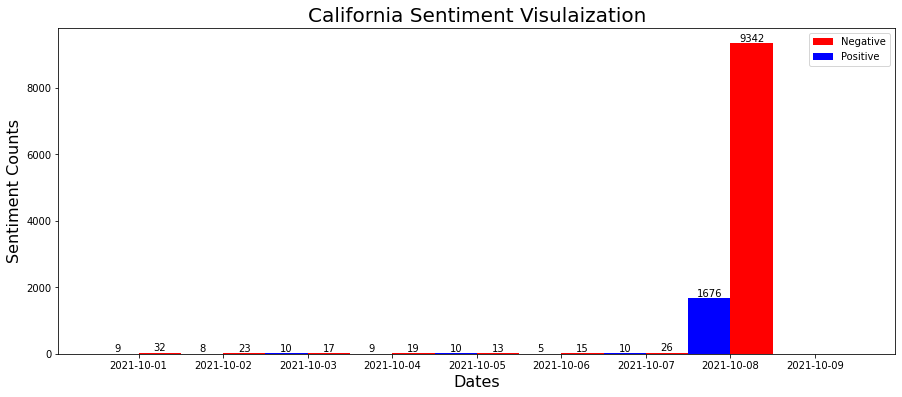

In [11]:
import matplotlib.pyplot as plt
import datetime

list_of_dates = []
negative_x = []
x_tick_labels = []
# Visualizes data based on formatted dataframes for date and sentiment...
def sentiment_visualization(date_foramtted_df, state):
    # Seperate the data based on sentiment.
    neg_sentiment_df = date_formatted_df.loc[date_formatted_df['sentiment']=='NEGATIVE']
    pos_sentiment_df = date_formatted_df.loc[date_formatted_df['sentiment']=='POSITIVE']
    # Collect unique date values
    neg_set_of_dates = set(neg_sentiment_df['date'])
    pos_set_of_dates = set(pos_sentiment_df['date'])
    set_of_dates = neg_set_of_dates.union(pos_set_of_dates)
    # added an additional date value at the end to assist in visualization issues during development.
    set_of_dates.add(max(set_of_dates) + datetime.timedelta(days=1))
    # Sort dates
    list_of_dates = sorted(list(set_of_dates))
    # Create X and Y values lists for Negative sentiments.
    negative_x = []
    negative_y = []
    for i in range(len(list_of_dates)):
        x_value = i+1 
        y_value = len(neg_sentiment_df.loc[date_formatted_df['date'] == list_of_dates[i]])
        negative_x.append(x_value)
        negative_y.append(y_value)
    # Create X and Y values lists for Positive sentiments.
    positive_x = []
    positive_y = []
    for i in range(len(list_of_dates)):
        x_value = (i+1) - 0.5 
        y_value = len(pos_sentiment_df.loc[date_formatted_df['date'] == list_of_dates[i]])
        positive_x.append(x_value)
        positive_y.append(y_value)
        
    
    # Reference: https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-
    # the-bar-on-each-bar-with-pyplot-barh
    # User: Franck Dernoncourt
    # Code referenced for textual values in the bar graph
    
    # Create plot and assign figure size
    fig, axs = plt.subplots(figsize=(15,6))
    # Convert datetime dates to strings to assign to the 'x ticks' on the plot graph
    x_tick_labels = []
    for date in list_of_dates:
        x_tick_labels.append(str(date))
    # General bar width
    bar_widths = 0.5
    # Seperatly creating both bar plots and assign to the same subplot
    negative_bar = axs.bar(negative_x, negative_y, width=bar_widths, align='edge', color='red', label='Negative')
    positive_bar = axs.bar(positive_x, positive_y, width=bar_widths, align='edge', color='blue', label='Positive')
    # Label bar graph values
    barlabels(negative_bar, axs)
    barlabels(positive_bar, axs)
    # Label x tick values
    plt.xticks(negative_x, x_tick_labels)
    axs.set_title((state + ' Sentiment Visulaization'), fontsize=20)
    axs.set_xlabel('Dates', fontsize=16)
    axs.set_ylabel('Sentiment Counts', fontsize=16)
    plt.legend()
    plt.show()
    return list_of_dates, negative_x, x_tick_labels
# Function used to label the bar graph values 
def barlabels(bar_graph, axs):
    for bar in bar_graph:
        if bar.get_height() > 0:
            bar_height = bar.get_height()
            axs.text(bar.get_x() + bar.get_width()/2, bar_height, '%d' % int(bar_height),
                     ha='center', va='bottom')

            
list_of_dates, negative_x, x_tick_labels = sentiment_visualization(date_formatted_df, 'California')

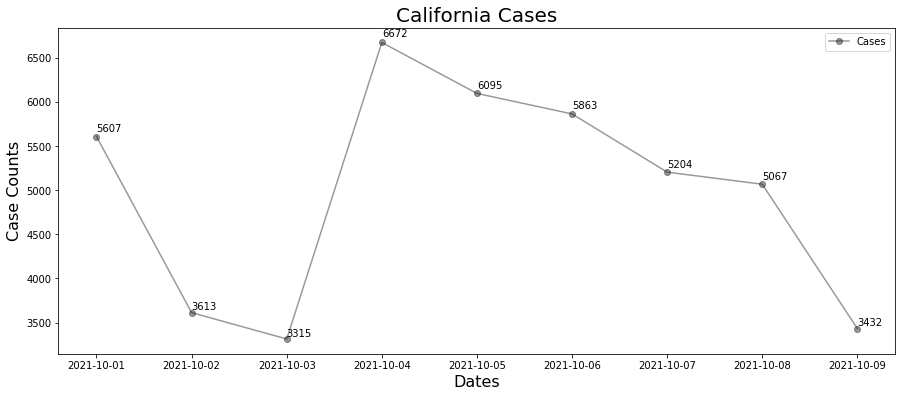

In [13]:
# Attempt at Loading Covid-19 data
# Load California Covid 19 Cases data by county
ca_covid_df = pd.read_csv("data/covid_data/covid19cases_test.csv")
# Drop majority of columns 
ca_covid_df = ca_covid_df.drop(['area_type', 'cumulative_cases', 'cumulative_deaths',
                                'cumulative_total_tests', 'cumulative_positive_tests', 
                                'cumulative_reported_cases', 'cumulative_reported_deaths'], axis=1)
# Read counties csv
counties = pd.read_csv("data/counties/ca_counties.csv")
cases_list = []
# Iterate through the list of days 
for date in list_of_dates:
# Select data based on a day
    formatted_covid_df = ca_covid_df[ca_covid_df['date'].isin([str(date)])]
# Select data based on each county's for the selected day
    county_covid_cases = formatted_covid_df[formatted_covid_df['area'].isin(list(counties['County']))]
# Summarize the number all of the cases that day
    cases_list.append(int(sum(list(county_covid_cases['cases']))))

# Testing graphical output of matplotlib... 
fig2, axs2 = plt.subplots(figsize=(15,6))
# Line Graph version
cases_line = axs2.plot(negative_x, cases_list, 'o-', alpha=0.4, color='black', label='Cases')
# Reference: https://stackoverflow.com/questions/22272081/label-python-data-points-on-plot
# User: falsetru
for point in range(len(list_of_dates)):
    axs2.annotate('%d' % int(cases_list[point]), xy=((point+1), 1.01*cases_list[point]))
# # Bar Graph equivalence.
# cases_bar = axs2.bar(negative_x, cases_list, width= 0.5, alpha=0.4, color='black', label='Cases')
# barlabels(cases_bar, axs2)

axs2.set_title('California Cases', fontsize=20)
axs2.set_xlabel('Dates', fontsize=16)
axs2.set_ylabel('Case Counts', fontsize=16)
plt.xticks(negative_x, x_tick_labels)
plt.legend()
plt.show()

In [72]:
ca_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from California counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:38:44.341007
(1/58) Alameda - 21 tweets: 2021-10-25 13:38:45.881042
(2/58) Alpine - 1000 tweets: 2021-10-25 13:39:09.837050
(3/58) Amador - 0 tweets: 2021-10-25 13:39:11.102162
(4/58) Butte - 1 tweets: 2021-10-25 13:39:12.396181
(5/58) Calaveras - 0 tweets: 2021-10-25 13:39:13.496967
(6/58) Colusa - 1000 tweets: 2021-10-25 13:39:36.111556
(7/58) Contra Costa - 19 tweets: 2021-10-25 13:39:37.566732
(8/58) Del Norte - 0 tweets: 2021-10-25 13:39:38.720221
(9/58) El Dorado - 0 tweets: 2021-10-25 13:39:39.831705
(10/58) Fresno - 7 tweets: 2021-10-25 13:39:41.169946
(11/58) Glenn - 1000 tweets: 2021-10-25 13:40:02.603418
(12/58) Humboldt - 3 tweets: 2021-10-25 13:40:03.850985
(13/58) Imperial - 0 tweets: 2021-10-25 13:40:05.220279
(14/58) Inyo - 1000 tweets: 2021-10-25 13:40:27.310050
(15/58) Kern - 0 tweets: 2021-10-25 13:40:28.652667
(16/58) Kings - 0 tweets: 2021-10-25 13:40:29.886437

In [73]:
fl_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from Florida counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:43:53.069049
(1/67) Alachua - 2 tweets: 2021-10-25 13:43:54.396436
(2/67) Baker - 0 tweets: 2021-10-25 13:43:55.864294
(3/67) Bay - 3 tweets: 2021-10-25 13:43:57.095982
(4/67) Bradford - 2 tweets: 2021-10-25 13:43:58.506500
(5/67) Brevard - 2 tweets: 2021-10-25 13:43:59.989494
(6/67) Broward - 27 tweets: 2021-10-25 13:44:02.865191
(7/67) Calhoun - 0 tweets: 2021-10-25 13:44:04.075572
(8/67) Charlotte - 1 tweets: 2021-10-25 13:44:06.441782
(9/67) Citrus - 1 tweets: 2021-10-25 13:44:07.913851
(10/67) Clay - 3 tweets: 2021-10-25 13:44:09.322266
(11/67) Collier - 4 tweets: 2021-10-25 13:44:11.197192
(12/67) Columbia - 0 tweets: 2021-10-25 13:44:12.497461
(13/67) De Soto - 1000 tweets: 2021-10-25 13:44:33.972711
(14/67) Dixie - 0 tweets: 2021-10-25 13:44:35.301368
(15/67) Duval - 1 tweets: 2021-10-25 13:44:36.607138
(16/67) Escambia - 0 tweets: 2021-10-25 13:44:38.432001
(17/67) Flagler - 

In [74]:
ny_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from New York counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:50:47.127010
(1/62) Albany - 2 tweets: 2021-10-25 13:50:48.532453
(2/62) Allegany - 0 tweets: 2021-10-25 13:50:50.087874
(3/62) Bronx - 415 tweets: 2021-10-25 13:51:09.882069
(4/62) Broome - 0 tweets: 2021-10-25 13:51:11.929999
(5/62) Cattaraugus - 1000 tweets: 2021-10-25 13:51:33.535964
(6/62) Cayuga - 1000 tweets: 2021-10-25 13:51:54.554562
(7/62) Chautauqua - 1 tweets: 2021-10-25 13:51:55.916112
(8/62) Chemung - 1000 tweets: 2021-10-25 13:52:17.777283
(9/62) Chenango - 1000 tweets: 2021-10-25 13:52:39.533305
(10/62) Clinton - 0 tweets: 2021-10-25 13:52:40.740557
(11/62) Columbia - 0 tweets: 2021-10-25 13:52:42.837750
(12/62) Cortland - 0 tweets: 2021-10-25 13:52:44.629477
(13/62) Delaware - 0 tweets: 2021-10-25 13:52:45.941733
(14/62) Dutchess - 6 tweets: 2021-10-25 13:52:47.189758
(15/62) Erie - 11 tweets: 2021-10-25 13:52:48.804933
(16/62) Essex - 1000 tweets: 2021-10-25 13:53:1

In [75]:
tx_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from Texas counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:58:00.572143
(1/254) Anderson - 1000 tweets: 2021-10-25 13:58:22.811629
(2/254) Andrews - 1000 tweets: 2021-10-25 13:58:45.415645
(3/254) Angelina - 1000 tweets: 2021-10-25 13:59:07.836704
(4/254) Aransas - 1000 tweets: 2021-10-25 13:59:29.363299
(5/254) Archer - 1000 tweets: 2021-10-25 13:59:50.296295
(6/254) Armstrong - 1000 tweets: 2021-10-25 14:00:12.225854
(7/254) Atascosa - 1000 tweets: 2021-10-25 14:00:45.014286
(8/254) Austin - 1000 tweets: 2021-10-25 14:01:06.418058
(9/254) Bailey - 1000 tweets: 2021-10-25 14:01:27.649272
(10/254) Bandera - 1000 tweets: 2021-10-25 14:01:48.893844
(11/254) Bastrop - 0 tweets: 2021-10-25 14:01:51.990935
(12/254) Baylor - 1000 tweets: 2021-10-25 14:02:13.239977
(13/254) Bee - 1000 tweets: 2021-10-25 14:02:34.524332
(14/254) Bell - 3 tweets: 2021-10-25 14:02:36.519826
(15/254) Bexar - 33 tweets: 2021-10-25 14:02:38.871012
(16/254) Blanco - 1000 twe

(140/254) Lamb - 1000 tweets: 2021-10-25 14:38:49.309231
(141/254) Lampasas - 1000 tweets: 2021-10-25 14:39:10.762286
(142/254) La Salle - 1000 tweets: 2021-10-25 14:39:32.756414
(143/254) Lavaca - 1000 tweets: 2021-10-25 14:39:53.370343
(144/254) Lee - 1000 tweets: 2021-10-25 14:40:15.248813
(145/254) Leon - 1000 tweets: 2021-10-25 14:40:37.113497
(146/254) Liberty - 0 tweets: 2021-10-25 14:40:40.910772
(147/254) Limestone - 0 tweets: 2021-10-25 14:40:42.102977
(148/254) Lipscomb - 1000 tweets: 2021-10-25 14:41:04.252068
(149/254) Live Oak - 1000 tweets: 2021-10-25 14:41:26.000914
(150/254) Llano - 1000 tweets: 2021-10-25 14:41:48.170697
(151/254) Loving - 0 tweets: 2021-10-25 14:41:49.349953
(152/254) Lubbock - 1000 tweets: 2021-10-25 14:42:10.793298
(153/254) Lynn - 1000 tweets: 2021-10-25 14:42:32.583014
(154/254) Madison - 1000 tweets: 2021-10-25 14:42:54.320934
(155/254) Marion - 1000 tweets: 2021-10-25 14:43:16.667794
(156/254) Martin - 0 tweets: 2021-10-25 14:43:18.060368
(157/

# References

California Counties: https://www.mapsofworld.com/usa/states/california/california-county-map.html

Florida Counties: https://www.mapsofworld.com/usa/states/florida/florida-county-map.html

New York Counties: https://www.mapsofworld.com/usa/states/new-york/new-york-county-map.html

Texas Counties: https://www.mapsofworld.com/usa/states/texas/texas-county-map.html